In [1]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

In [2]:
import os
#os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch

# Format input data

In [3]:
patient = 'F16'
PATH = "../../Data/echidna3/"
path = os.path.join(PATH, patient + ".h5ad")
print(path)

../../Data/echidna3/F16.h5ad


In [4]:
w_path = os.path.join(PATH, "all_cellranger_w.csv")
w_path

'../../Data/echidna3/all_cellranger_w.csv'

In [5]:
from echidna.utils import *

/Users/mingxuanzhang/Desktop/echidna3/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
W = read_W(w_path)

In [7]:
X = sc.read_h5ad(path)
X

AnnData object with n_obs × n_vars = 11074 × 25043
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'sample', 'patient', 'condition', 'barcode_orig', 'barcode_pat', 'samples_per_patient', 'timepoint', 'Before.During.After', 'Sample_J', 'Gender', 'Treatment_phase', 'Drug', 'tissue', 'Mutation', 'sample_group', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'clonotype_id', 'chain', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'frequency', 'proportion', 'cdr3s_aa', 'cdr3s_nt', 'inkt_evidence', 'mait_evidence', 'tcr', 'mait', 'inkt', 'both_chains', 'clone_size', 'mait_inkt', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_origi

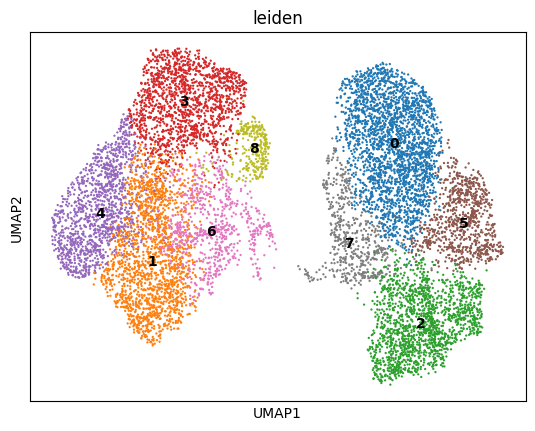

In [8]:
sc.pl.umap(X, color=['leiden'], legend_loc='on data')

In [9]:
X_obs, W_obs, z_obs, pi_obs = prepare_input(X, W, sample_name=patient, 
                                            timepoints=['pre', 'post1_pre2'], n_subsamples=3000, device="cpu")
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

torch.Size([2, 3000, 25043])
torch.Size([2, 25043])
torch.Size([2, 3000])
torch.Size([2, 9])


# Train model

In [10]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig
from echidna.eval import get_learned_params

In [13]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_timepoints = X_obs.shape[0]
config.num_clusters = pi_obs.shape[-1]
config.q_corr_init = 1e-2
config.q_shape_rate_scaler = 10.0
config.eta_mean_init = 2.0
config.eps = 5e-3

In [14]:
echidna = Echidna(config, mode="MT", device="cpu")

In [15]:
echidna, loss = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.1, n_epochs=1000)

100%|██████████| 1000/1000 [08:56<00:00,  1.87it/s]


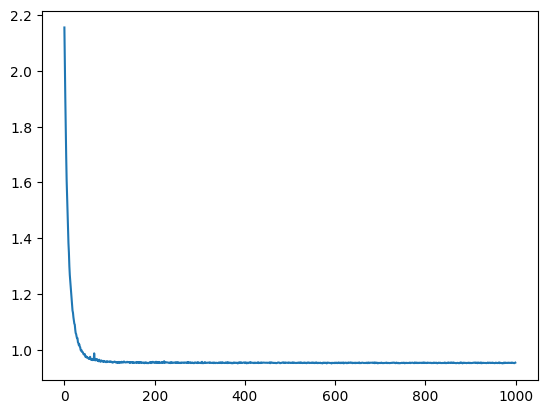

In [16]:
plt.plot(loss)

In [17]:
params = get_learned_params(echidna, X_obs, W_obs, pi_obs, z_obs)

# Look at trained model

In [18]:
import torch.nn.functional as F
from echidna.eval import sample_W, sample_X, plot_true_vs_pred, sample_C
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
params.keys()

odict_keys(['_INPUT', 'G:genes', 'K:clusters', 'scale', 'cholesky_corr', 'eta', 'genes', 'timepoints_w', 'W', 'timepoints_c', 'c', 'X_0', 'X_1', '_RETURN'])

In [20]:
eta = F.softplus(params['eta']['value'].T)
c_on = params['c']['value'][0, :, :]
c_pre = params['c']['value'][1, :, :]
c_shape = pyro.param('c_shape')
lib_on = X_obs[0, :, :].sum(-1, keepdim=True) * 1e-5
lib_pre = X_obs[1, :, :].sum(-1, keepdim=True) * 1e-5
z_on = z_obs[0, :]
z_pre = z_obs[1, :]

In [21]:
X_learned_on = sample_X(X_obs.numpy(), c_on, eta, z_on.numpy(), lib_on)
X_learned_pre = sample_X(X_obs.numpy(), c_pre, eta, z_pre.numpy(), lib_on)

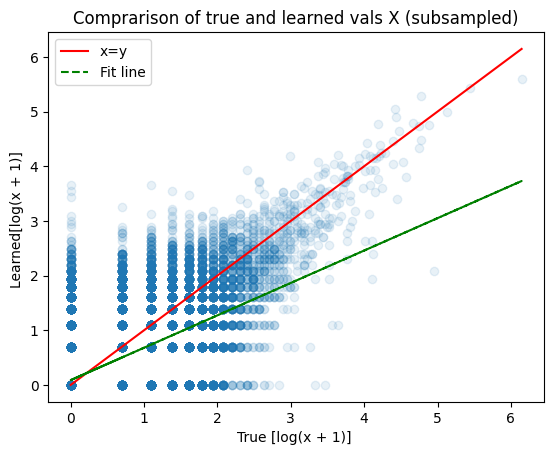

In [22]:
plot_true_vs_pred(X_learned_on, X_obs[0, :, :].numpy(), log_scale=True, name='X')

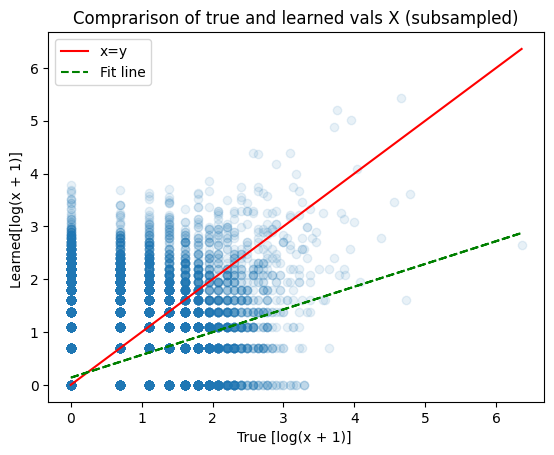

In [23]:
plot_true_vs_pred(X_learned_pre, X_obs[-1, :, :].numpy(), log_scale=True, name='X')

In [24]:
W_learned = np.array(sample_W(pi_obs, eta))
W_obs_np = W_obs.numpy()

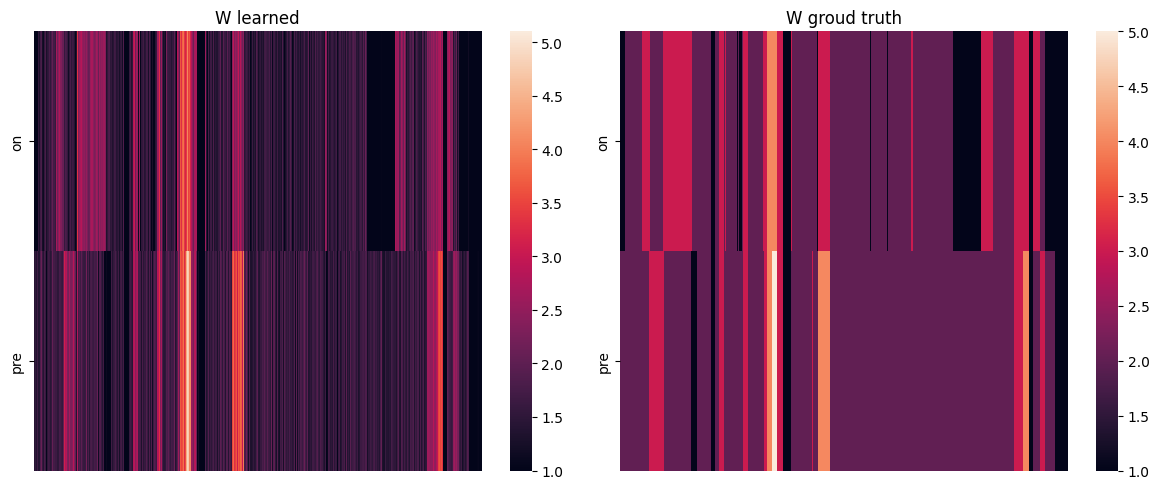

In [25]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(W_learned, ax=axes[0], vmin=1)
axes[0].set_title('W learned')
axes[0].set_xticks([])
axes[0].set_yticklabels(['on', 'pre'])

# Plot the second heatmap
sns.heatmap(W_obs_np, ax=axes[1])
axes[1].set_title("W groud truth")
axes[1].set_xticks([])
axes[1].set_yticklabels(['on', 'pre'])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 100x100 with 0 Axes>

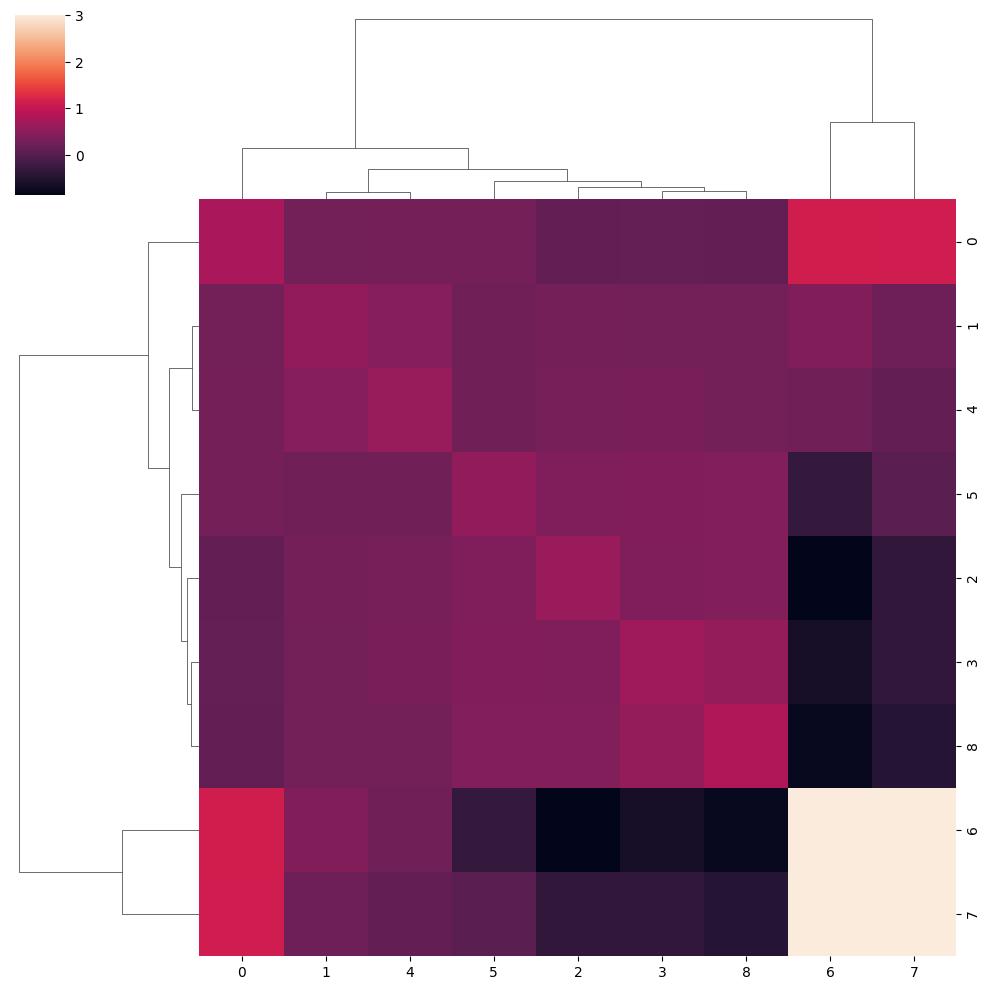

In [26]:
plt.figure(figsize=(1, 1)) 
sns.clustermap(torch.cov(eta).cpu().detach().numpy(), vmax=3)
plt.show()

In [27]:
from echidna.eval import eta_cov_tree, assign_clones, learned_cov

In [28]:
params.keys()

odict_keys(['_INPUT', 'G:genes', 'K:clusters', 'scale', 'cholesky_corr', 'eta', 'genes', 'timepoints_w', 'W', 'timepoints_c', 'c', 'X_0', 'X_1', '_RETURN'])

In [29]:
L = params['cholesky_corr']['value']
scale = params['scale']['value']

In [30]:
cov = learned_cov(L, scale)

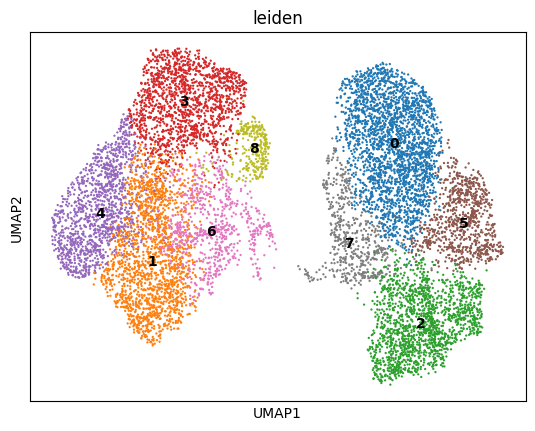

In [31]:
sc.pl.umap(X, color=['leiden'], legend_loc='on data')

In [32]:
from echidna.eval import eta_cov_tree_elbow_thresholding, eta_cov_tree

Knee point:  7
Threshold:  3.134914809306964


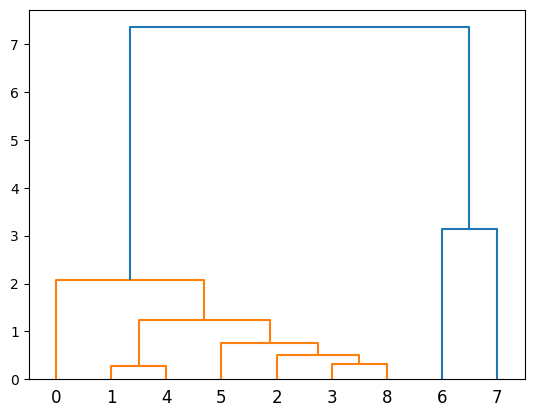

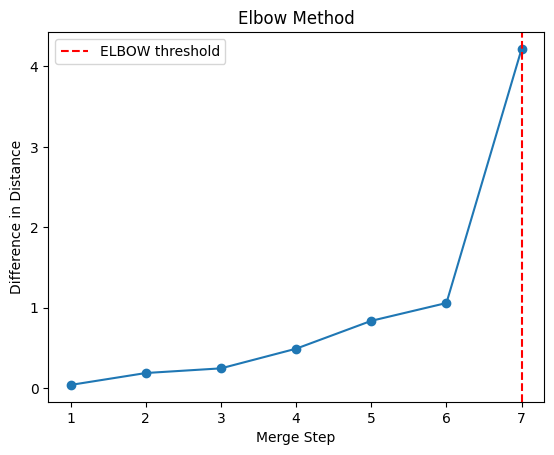

In [33]:
dn = eta_cov_tree_elbow_thresholding(eta, plot_elbow=True)

In [34]:
assign_clones(dn, X)

/Users/mingxuanzhang/Desktop/echidna3/notebooks/../echidna/eval.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in X.obs["leiden"]]


In [35]:
X

AnnData object with n_obs × n_vars = 11074 × 25043
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'sample', 'patient', 'condition', 'barcode_orig', 'barcode_pat', 'samples_per_patient', 'timepoint', 'Before.During.After', 'Sample_J', 'Gender', 'Treatment_phase', 'Drug', 'tissue', 'Mutation', 'sample_group', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'clonotype_id', 'chain', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'frequency', 'proportion', 'cdr3s_aa', 'cdr3s_nt', 'inkt_evidence', 'mait_evidence', 'tcr', 'mait', 'inkt', 'both_chains', 'clone_size', 'mait_inkt', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_origi

In [36]:
my_color_list = ['c', 'm', 'y'] 

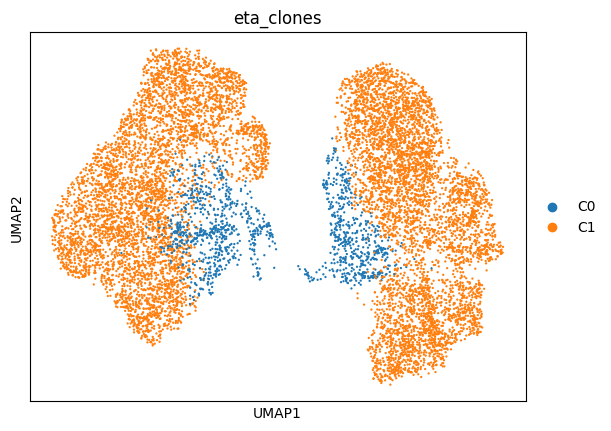

In [37]:
sc.pl.umap(X, color=['eta_clones'])

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [39]:
color_dict = {6:'c' , 9: 'c', 
              1: 'm', 2: 'm', 5: 'm',
              10: 'y', 3:'y', 7:'y', 8:'y', 0:'y', 4:'y'
             }

In [40]:
default_color = 'y'

In [41]:
def link_color_func(idx):
    return color_dict.get(idx, default_color)

In [42]:
dn['leaves']

[3, 11, 1, 2, 6, 10, 4, 8, 0, 9, 5, 7]

In [43]:
dflt_col = "#808080"
D_leaf_colors = {6: 'c',
                 9: 'c',
                 1: 'm',
                 2: 'm',
                 5: 'm',
                 10: 'y', 3:'y', 7:'y', 8:'y', 0:'y', 4:'y'
                 }

In [ ]:
Z = linkage(torch.cov(eta).cpu().detach().numpy(), 'average')
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else D_leaf_colors[x]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col

# Dendrogram
D = dendrogram(Z=Z, color_threshold=None, link_color_func=lambda x: link_cols[x])

In [190]:
def iterative_adaptive_clustering(eta, n_iterations, adaptive_cutoff):
    all_clusters = []
    data = torch.cov(eta).cpu().detach().numpy()
    current_labels = None
    for i in range(n_iterations):
        print(f"Iteration {i + 1}")

        # cluster
        Z = linkage(data, 'average')

        # get current assignments
        base_cutoff = adaptive_cutoff[i]
        clusters = fcluster(Z, base_cutoff, criterion='distance')
        print(f"Iteration {i + 1} - Cluster labels:", clusters)
        if i != 0:
            dn = dendrogram(Z, color_threshold=base_cutoff, labels=current_labels)
        else:
            dn = dendrogram(Z, color_threshold=base_cutoff)
        current_labels = dn['ivl']
        plt.show()

        # remove most obvious clusters
        cluster_to_remove = np.bincount(clusters).argmin()
        dim_to_remove = np.where(clusters == cluster_to_remove + 1)[0]
        dim_to_remove_str = [str(d) for d in dim_to_remove]
        print(dim_to_remove_str)
        # Remove the points in the largest cluster
        data = np.delete(data, dim_to_remove, axis=0)  # Remove rows
        data = np.delete(data, dim_to_remove, axis=1)  # Remove columns
        current_labels = [l for l in current_labels if l not in dim_to_remove_str]
        
        
        # If no data left, break the loop
        if len(data) == 0:
            print("No data left to cluster.")
            break
        
        all_clusters.append(clusters)

    return all_clusters

In [191]:
eta.shape

torch.Size([11, 23648])

Iteration 1
Iteration 1 - Cluster labels: [2 2 2 2 2 2 1 2 2 1 2]


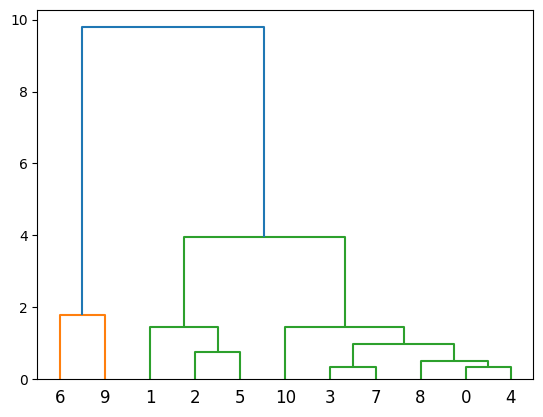

['6', '9']
Iteration 2
Iteration 2 - Cluster labels: [2 1 1 2 2 1 2 2 2]


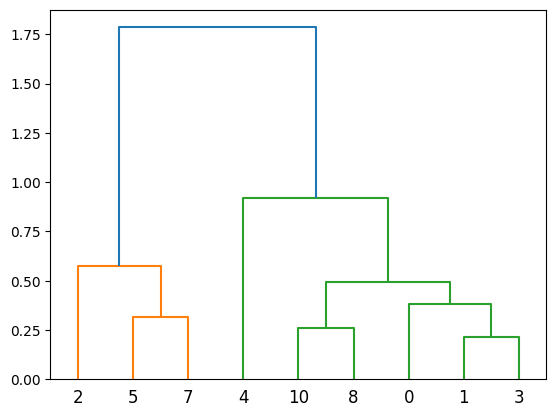

['1', '2', '5']
Iteration 3
Iteration 3 - Cluster labels: [1 1 1 1 1 2]


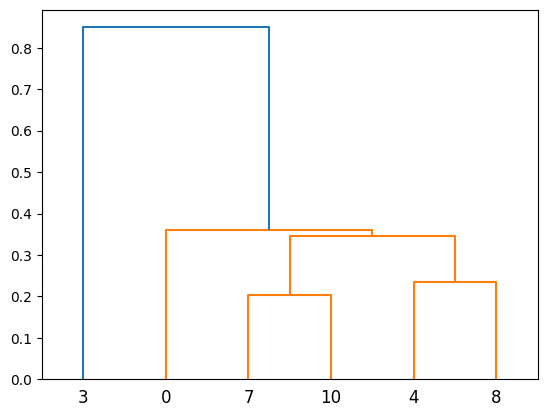

['0', '1', '2', '3', '4']


In [192]:
clst = iterative_adaptive_clustering(eta, n_iterations=3, adaptive_cutoff=[4.0, 1.0, 0.5])

In [151]:
def merge_clusters_voting(cluster_labels):
    n_samples, n_iterations = len(cluster_labels[0]), len(cluster_labels)
    merged_labels = np.zeros(n_samples, dtype=int)
    
    for i in range(n_samples):
        # Count the votes for each cluster label
        votes = np.zeros(n_iterations)
        for j in range(n_iterations):
            votes[cluster_labels[j][i] - 1] += 1  # Cluster labels start from 1
        
        # Assign the point to the cluster with the most votes
        merged_labels[i] = np.argmax(votes) + 1  # Add 1 to match cluster label indexing
        
    return merged_labels

Iteration 1
Iteration 1 - Cluster labels: [2 2 2 2 2 2 1 2 2 1 2]


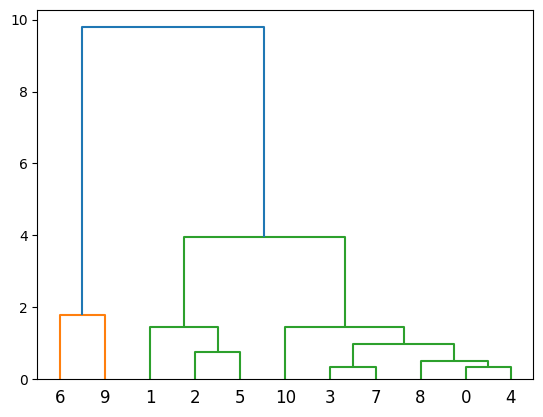

['6', '9']
Iteration 2
Iteration 2 - Cluster labels: [2 1 1 2 2 1 2 2 2]


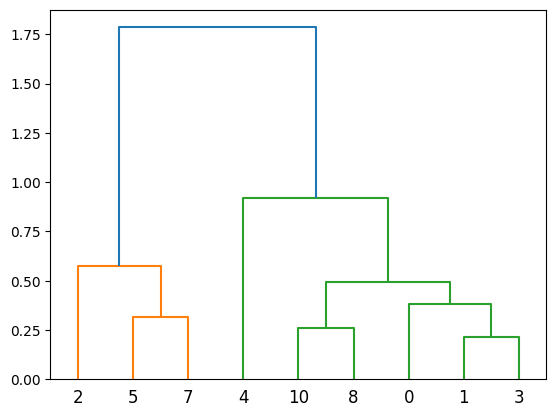

['1', '2', '5']
Iteration 3
Iteration 3 - Cluster labels: [1 1 1 1 1 2]


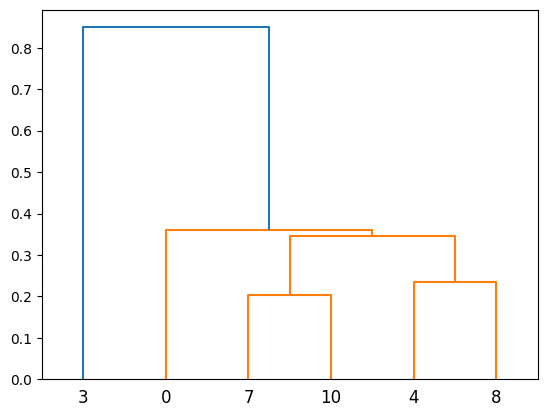

['0', '1', '2', '3', '4']


[array([2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2], dtype=int32),
 array([2, 1, 1, 2, 2, 1, 2, 2, 2], dtype=int32),
 array([1, 1, 1, 1, 1, 2], dtype=int32)]

In [152]:
clst = iterative_adaptive_clustering(eta, n_iterations=3, adaptive_cutoff=[4.0, 1.0, 0.5])
clst

In [70]:
clst_voted = merge_clusters_voting(np.array(clst))
clst_voted

IndexError: index 5 is out of bounds for axis 0 with size 4